In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
import zipfile

zip_path = "/content/drive/MyDrive/İNME VERİ SETİ 3.zip" 
extract_path = "/content/dataset2"  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Zip dosyası başarıyla açıldı!")


Zip dosyası başarıyla açıldı!


In [3]:
import os
import shutil

# Kaynak klasörler
kanama_path = "/content/dataset2/I╠çNME VERI╠ç SETI╠ç 3/Kanama/PNG"
iskemi_path = "/content/dataset2/I╠çNME VERI╠ç SETI╠ç 3/I╠çskemi/PNG"

# Hedef klasör
target_path = "/content/dataset/inme_var"
os.makedirs(target_path, exist_ok=True)

# Taşıma fonksiyonu
def move_png_files(src_dir, dst_dir):
    for file_name in os.listdir(src_dir):
        if file_name.endswith(".png"):
            full_src_path = os.path.join(src_dir, file_name)
            full_dst_path = os.path.join(dst_dir, file_name)
            shutil.move(full_src_path, full_dst_path)

# Taşıma işlemi
move_png_files(kanama_path, target_path)
move_png_files(iskemi_path, target_path)

print("İskemi ve Kanama PNG dosyaları başarıyla inme_var klasörüne taşındı.")


İskemi ve Kanama PNG dosyaları başarıyla inme_var klasörüne taşındı.


In [4]:
import os
import shutil

# Kaynak klasör (dikkat: "inme yok" klasör adı boşluk içeriyor)
inme_yok_src = "/content/dataset2/I╠çNME VERI╠ç SETI╠ç 3/I╠çnme Yok"

# Hedef klasör
inme_yok_dst = "/content/dataset/inme_yok"
os.makedirs(inme_yok_dst, exist_ok=True)

# Taşıma işlemi
for file_name in os.listdir(inme_yok_src):
    if file_name.endswith(".png"):
        src_path = os.path.join(inme_yok_src, file_name)
        dst_path = os.path.join(inme_yok_dst, file_name)
        shutil.move(src_path, dst_path)

print("inme yok PNG dosyaları başarıyla inme_yok klasörüne taşındı.")


inme yok PNG dosyaları başarıyla inme_yok klasörüne taşındı.


In [5]:
from pathlib import Path

base_path = Path("/content/dataset")
stroke_present_path = base_path / "inme_var"
no_stroke_path = base_path / "inme_yok"

# Count .png images in each folder
stroke_present_count = len(list(stroke_present_path.glob("*.png")))
no_stroke_count = len(list(no_stroke_path.glob("*.png")))

print(f"There are {stroke_present_count} images in the Stroke Present folder.")
print(f"There are {no_stroke_count} images in the No Stroke folder.")


There are 2223 images in the Stroke Present folder.
There are 4551 images in the No Stroke folder.


In [6]:
import os, random, shutil
from pathlib import Path

random.seed(42)

# Base dataset directory
base = Path("/content/dataset") 

# Target directory for split dataset
dest = Path("/content/dataset_split")  

# Split ratios
splits = {
    "train": 0.7,
    "valid": 0.15,
    "test": 0.15
}

# Class names
classes = ['inme_var', 'inme_yok']

# Create folders for each split and class
for split in splits:
    for cls in classes:
        (dest/split/cls).mkdir(parents=True, exist_ok=True)

# Shuffle and split files for each class
for cls in classes:
    files = list((base/cls).glob("*.png"))
    random.shuffle(files)

    n = len(files)
    train_end = int(splits['train'] * n)
    valid_end = train_end + int(splits['valid'] * n)

    split_files = {
        "train": files[:train_end],
        "valid": files[train_end:valid_end],
        "test": files[valid_end:]
    }

    # Copy files to corresponding folders
    for split, filelist in split_files.items():
        for f in filelist:
            shutil.copy(f, dest/split/cls/f.name)

print("Files successfully split into train / valid / test sets.")


Files successfully split into train / valid / test sets.


In [8]:
from pathlib import Path

base_path = Path("/content/dataset_split")  # split dataset

splits = ["train", "valid", "test"]
classes = ["inme_var", "inme_yok"]

label_map = {
    "inme_var": "Stroke Present",
    "inme_yok": "No Stroke"
}

for split in splits:
    print(f"\n{split.upper()} folder:")
    for cls in classes:
        cls_path = base_path / split / cls
        count = len(list(cls_path.glob("*.png")))
        print(f"{label_map[cls]:>15}: {count} images")



TRAIN folder:
 Stroke Present: 1556 images
      No Stroke: 3185 images

VALID folder:
 Stroke Present: 333 images
      No Stroke: 682 images

TEST folder:
 Stroke Present: 334 images
      No Stroke: 684 images


In [8]:

from fastai.vision.all import *
set_seed(42, reproducible=True)


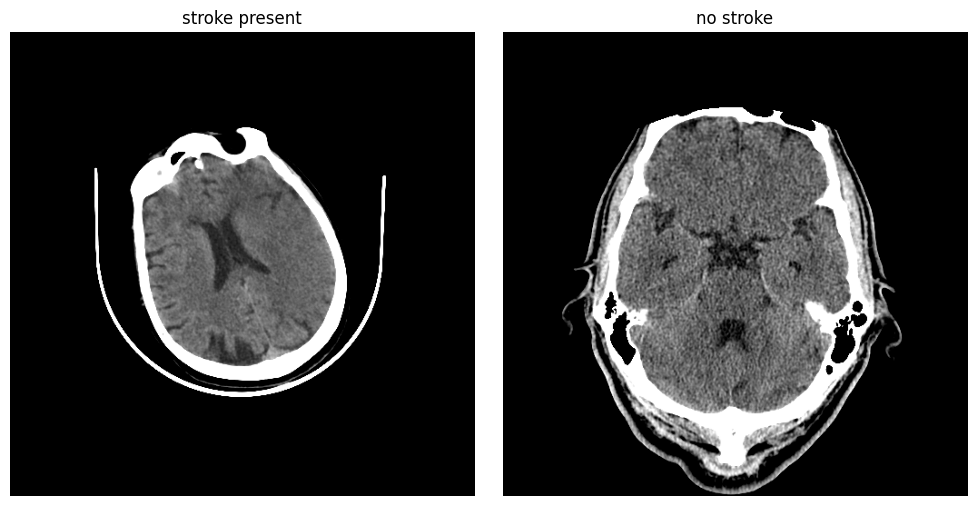

In [93]:
from PIL import Image
import matplotlib.pyplot as plt

# Birer örnek seç
img_var = list((Path("/content/dataset_split/train/inme_var")).glob("*.png"))[0]
img_yok = list((Path("/content/dataset_split/train/inme_yok")).glob("*.png"))[0]


var_img = Image.open(img_var)
yok_img = Image.open(img_yok)


fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(var_img, cmap='gray')
axs[0].set_title("stroke present")
axs[0].axis("off")

axs[1].imshow(yok_img, cmap='gray')
axs[1].set_title("no stroke")
axs[1].axis("off")

plt.tight_layout()
plt.show()


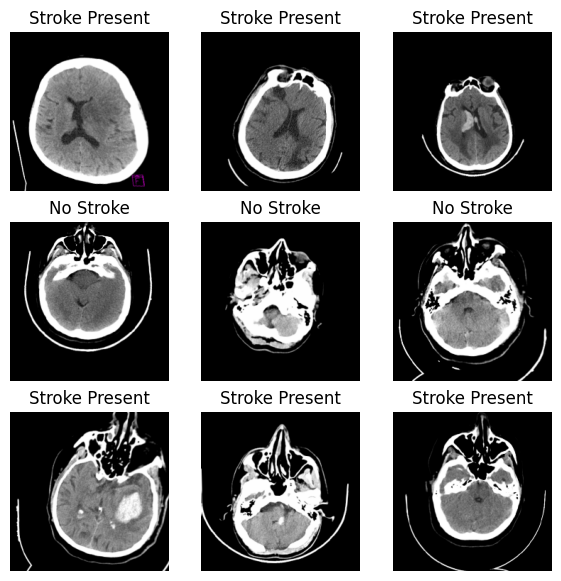

In [98]:
from fastai.vision.all import *

path = Path("/content/dataset_split")

def eng_label(file_path):
    name = file_path.parent.name
    return "Stroke Present" if name == "inme_var" else "No Stroke"


dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=eng_label,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, max_rotate=5., flip_vert=False)
)


dls = dblock.dataloaders(path)
dls.show_batch(max_n=9, figsize=(7,7))



In [99]:
for f in get_image_files(path):
    print(f"{f.name} -> {eng_label(f)}")
    break


14375.png -> No Stroke


In [102]:
label_map = {"inme_var": "Stroke Present", "inme_yok": "No Stroke"}

print("Class labels:", dls.vocab)
print("Number of classes:", dls.c)

Class labels: ['No Stroke', 'Stroke Present']
Number of classes: 2


In [103]:
xb, yb = dls.one_batch()
print(f"Input batch shape (xb): {xb.shape}")
print(f"Label batch shape (yb): {yb.shape}")
print(f"Class labels (vocab): {dls.vocab}")
print(f"Number of classes: {dls.c}")


Input batch shape (xb): torch.Size([64, 3, 224, 224])
Label batch shape (yb): torch.Size([64])
Class labels (vocab): ['No Stroke', 'Stroke Present']
Number of classes: 2


In [14]:
dblock.summary(Path("/content/dataset_split"))

Setting-up type transforms pipelines
Found 6774 items
2 datasets of sizes 4741,1015
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/dataset_split/train/inme_yok/14742.png
    applying PILBase.create gives
      PILImage mode=RGB size=512x512
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/dataset_split/train/inme_yok/14742.png
    applying parent_label gives
      inme_yok
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=512x512, TensorCategory(1))


Found 6774 items
2 datasets of sizes 4741,1015
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeli

In [67]:
from torch.nn import CrossEntropyLoss
from torch import tensor

weights = tensor([2.05, 1.0]).cuda()  # inme_var daha az olduğu için ağırlık veriyoruz


In [68]:
learn = vision_learner(dls, resnet18,
                       loss_func=CrossEntropyLoss(weight=weights),
                       metrics=accuracy)

learn.fine_tune(1)


epoch,train_loss,valid_loss,accuracy,time
0,0.845732,0.475127,0.803941,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.483934,0.318437,0.863054,00:10


In [69]:
# 4. (B.7) Ağırlık başlatma örneği – sadece teorik gösterim amaçlı
import torch.nn as nn

def init_weights_kaiming(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

dummy_model = resnet18()
dummy_model.apply(init_weights_kaiming)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

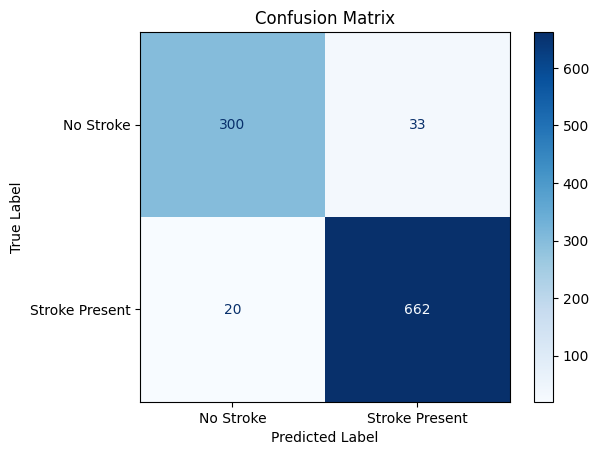

In [104]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

preds, targs = learn.get_preds()
pred_labels = preds.argmax(dim=1)

cm = confusion_matrix(targs, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dls.vocab)

disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [105]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(targs, pred_labels, target_names=dls.vocab))



Classification Report:
                precision    recall  f1-score   support

     No Stroke       0.94      0.90      0.92       333
Stroke Present       0.95      0.97      0.96       682

      accuracy                           0.95      1015
     macro avg       0.95      0.94      0.94      1015
  weighted avg       0.95      0.95      0.95      1015



In [72]:
# Test dosyalarını yükle
test_files = get_image_files(Path("/content/dataset_split/test"))

# Test için DataLoader oluştur
test_dl = learn.dls.test_dl(test_files, with_labels=True)


Test Set - stroke present: 334, no stroke: 684


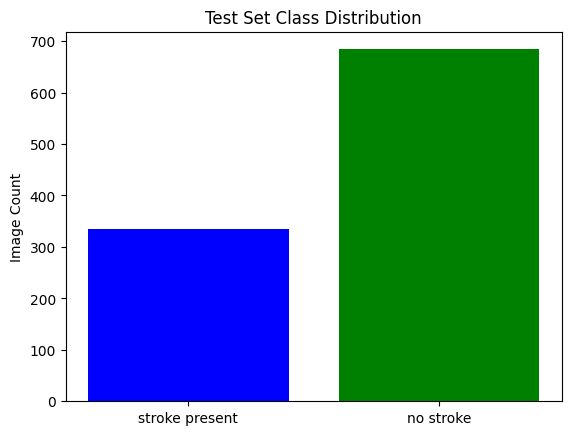

In [91]:
test_var_count = len(list((Path("/content/dataset_split/test/inme_var")).glob("*.png")))
test_yok_count = len(list((Path("/content/dataset_split/test/inme_yok")).glob("*.png")))

print(f"Test Set - stroke present: {test_var_count}, no stroke: {test_yok_count}")

# Grafik ile gösterim
import matplotlib.pyplot as plt
plt.bar(['stroke present', 'no stroke'], [test_var_count, test_yok_count], color=['blue', 'green'])
plt.title("Test Set Class Distribution")
plt.ylabel("Image Count")
plt.show()


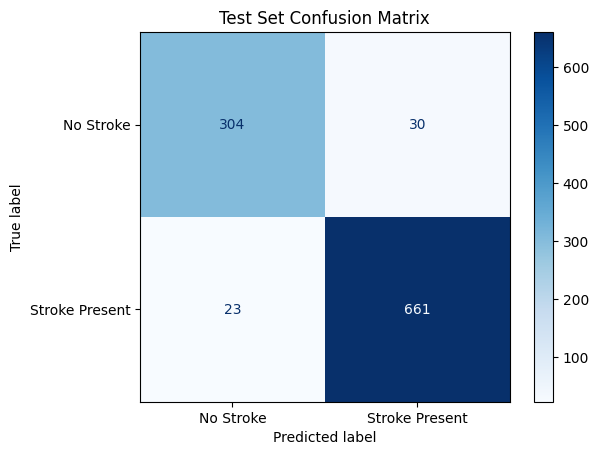

                precision    recall  f1-score   support

     No Stroke       0.93      0.91      0.92       334
Stroke Present       0.96      0.97      0.96       684

      accuracy                           0.95      1018
     macro avg       0.94      0.94      0.94      1018
  weighted avg       0.95      0.95      0.95      1018



In [106]:
preds, targs = learn.get_preds(dl=test_dl)
pred_labels = preds.argmax(dim=1)

# Confusion Matrix ve Rapor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(targs, pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=dls.vocab)
disp.plot(cmap='Blues')
plt.title("Test Set Confusion Matrix")
plt.show()

print(classification_report(targs, pred_labels, target_names=dls.vocab))

SuggestedLRs(valley=2.0892961401841603e-05)

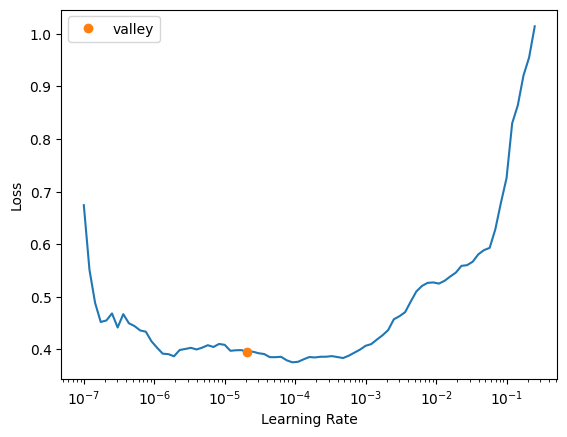

In [75]:
learn.lr_find()


epoch,train_loss,valid_loss,accuracy,time
0,0.359116,0.282162,0.902463,00:10
1,0.319512,0.221839,0.919212,00:10
2,0.248172,0.195406,0.916256,00:10
3,0.177119,0.179722,0.936946,00:10
4,0.146027,0.153744,0.947783,00:10


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

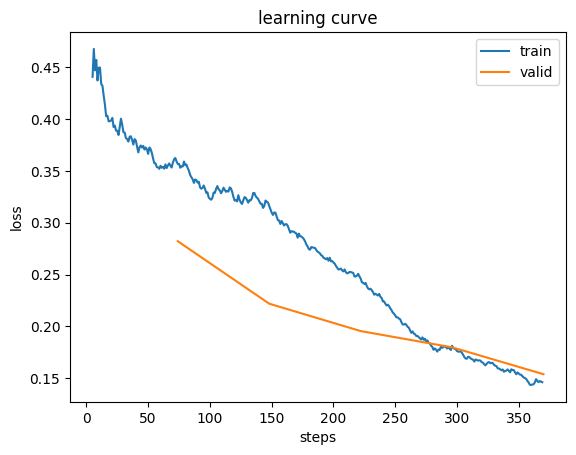

In [76]:
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(1e-5, 1e-3))

learn.recorder.plot_loss()

In [77]:
learn.summary()


Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

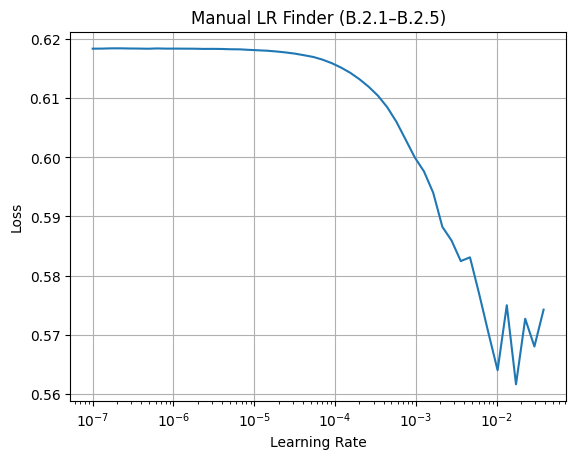

In [78]:
from fastai.vision.all import *
import torch
import matplotlib.pyplot as plt


xb_fastai, yb_fastai = dls.one_batch()

# FastAI'den native PyTorch tensorlara dönüştür
xb = torch.as_tensor(xb_fastai.cpu().numpy(), dtype=torch.float32).cuda()
yb = torch.as_tensor(yb_fastai.cpu().numpy(), dtype=torch.long).cuda()

# Model
model = resnet18(num_classes=dls.c).cuda()
loss_fn = torch.nn.CrossEntropyLoss()

lr = 1e-7
lrs = []
losses = []

for i in range(50):
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    model.train()
    opt.zero_grad()

    preds = model(xb)
    loss = loss_fn(preds, yb)
    loss.backward()
    opt.step()

    lrs.append(lr)
    losses.append(loss.item())
    lr *= 1.3  


plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Manual LR Finder (B.2.1–B.2.5)")
plt.grid()
plt.show()


In [79]:
learn.export("/content/stroke_model.pkl")


In [80]:
learn.save("stroke_model")


Path('models/stroke_model.pth')

In [81]:
from fastai.vision.all import *
learn_inf = load_learner("/content/stroke_model.pkl")


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [82]:
from pathlib import Path

test_path = Path("/content/dataset_split/test")
test_files = get_image_files(test_path)
test_dl = learn_inf.dls.test_dl(test_files, with_labels=True)

In [83]:
preds, targs = learn_inf.get_preds(dl=test_dl)
pred_labels = preds.argmax(dim=1)


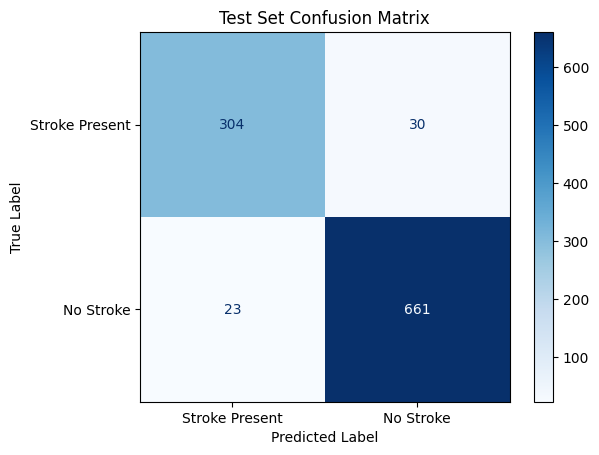

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

label_map = {"inme_var": "Stroke Present", "inme_yok": "No Stroke"}
english_labels = [label_map[label] for label in learn_inf.dls.vocab]

cm = confusion_matrix(targs, pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=english_labels)
disp.plot(cmap='Blues')
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


epoch,train_loss,valid_loss,accuracy,time
0,0.706441,0.451473,0.799015,00:20


epoch,train_loss,valid_loss,accuracy,time
0,0.623134,0.387879,0.837438,00:23
1,0.390544,0.258004,0.906404,00:23
2,0.273622,0.193909,0.935961,00:23
3,0.210629,0.220873,0.917241,00:23


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

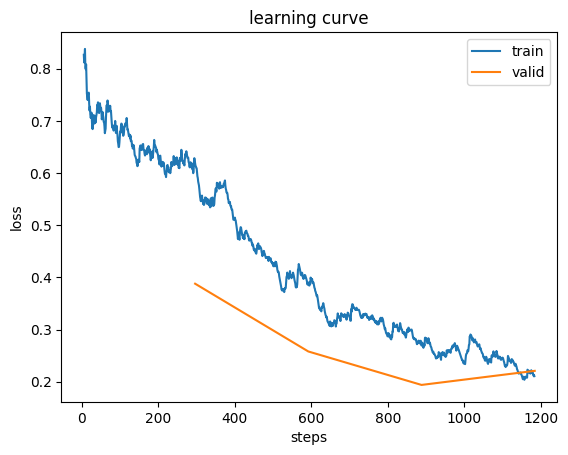

In [85]:
# Advanced: Model Capacity Test with ResNet50 (B.6)
from torchvision.models import resnet50


dls_resnet50 = dblock.dataloaders(path, bs=16)

learn50 = vision_learner(dls_resnet50, resnet50,
                         loss_func=CrossEntropyLoss(weight=weights),
                         metrics=accuracy)

learn50.freeze()
learn50.fit_one_cycle(1)

learn50.unfreeze()
learn50.fit_one_cycle(4, lr_max=slice(1e-5, 1e-3))  
learn50.recorder.plot_loss()


In [86]:
# ResNet18 - Test seti değerlendirme
test_dl18 = learn.dls.test_dl(test_files, with_labels=True)
preds18, targs18 = learn.get_preds(dl=test_dl18)
pred_labels18 = preds18.argmax(dim=1)

from sklearn.metrics import accuracy_score
acc18 = accuracy_score(targs18, pred_labels18)
print(f"ResNet18 Accuracy: {acc18:.4f}")


ResNet18 Accuracy: 0.9479


In [87]:
# ResNet50 - Test seti değerlendirme
test_dl50 = learn50.dls.test_dl(test_files, with_labels=True)
preds50, targs50 = learn50.get_preds(dl=test_dl50)
pred_labels50 = preds50.argmax(dim=1)

acc50 = accuracy_score(targs50, pred_labels50)
print(f"ResNet50 Accuracy: {acc50:.4f}")


ResNet50 Accuracy: 0.9165


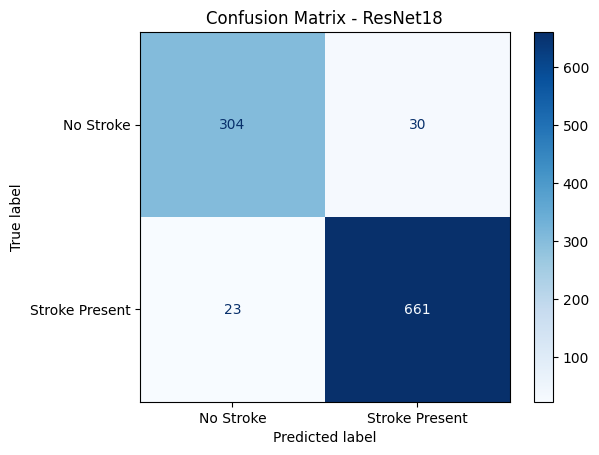

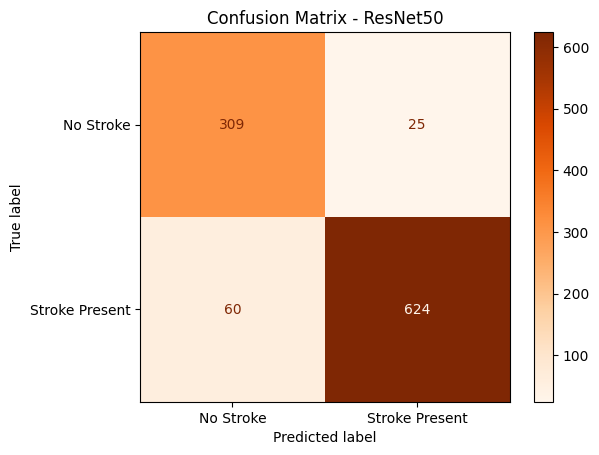

In [112]:
from sklearn.metrics import ConfusionMatrixDisplay

# ResNet18
cm18 = confusion_matrix(targs18, pred_labels18)
disp18 = ConfusionMatrixDisplay(cm18, display_labels=dls.vocab)
disp18.plot(cmap='Blues')
plt.title("Confusion Matrix - ResNet18")
plt.show()

# ResNet50
cm50 = confusion_matrix(targs50, pred_labels50)
disp50 = ConfusionMatrixDisplay(cm50, display_labels=dls.vocab)
disp50.plot(cmap='Oranges')
plt.title("Confusion Matrix - ResNet50")
plt.show()
